In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
from bicycle import *
from bicycle_control import *

In [3]:
import sys 
sys.path.append('..')
from codeprint import RawCode

# Stanley Control

In [4]:
code = RawCode('bicycle_control.py')
code.show('Stanley')

class Stanley():
    def __init__(self, line_coeff, gain, gamma_max):
        self.line_coeff = line_coeff
        self.theta_d = np.arctan2(-line_coeff[0], line_coeff[1])
        self.gain = gain
        self.gamma_max = gamma_max

    def ctrl(self, state, v):
        convert_angle = lambda x: x if (-np.pi < x)&(x <= np.pi) \
                                    else x - np.sign(x)*np.pi*2
        x, y = state[:2]
        theta = state[2]
        a, b, c = self.line_coeff

        heading_err = convert_angle(self.theta_d - theta)
        crosstrack_err = -(a*x+b*y+c)/np.sqrt(LA.norm([a, b]))
        gamma = heading_err + np.arctan2(self.gain*crosstrack_err, v)
        if abs(gamma) > self.gamma_max: gamma = np.sign(gamma)*self.gamma_max
        
        return gamma



### Bicycle Class : BicycleModel + Visualization

In [5]:
bicycle = Bicycle(L=2, dt=0.1, model_type='front')
bicycle.view = [-5, 20, -5, 20]

### Bicycle 

In [6]:
start = [0,5,-0]
bicycle.set_state(start, 0)

### Path

In [7]:
def draw_line(line):
    ax = plt.gca()
    xx = np.arange(-20,20,0.1)
    ax.plot(xx, line(xx), 'k--')
a, b, c = -1, 2, 3
line = lambda x: -a*x/b - c/b

### Visualization

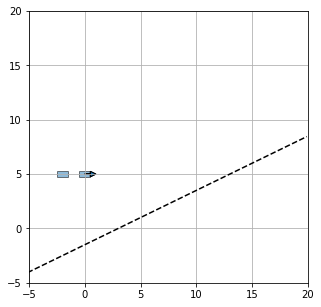

In [8]:
fig, ax = plt.subplots(figsize=[5,5])
draw_line(line)
bicycle.show()

In [36]:
ctrl = Stanley([a, b, c], gain=0.5, gamma_max=np.pi/4)

In [42]:
def simulation(start):
    # make dataframe for recording simulation
    state_names = ['x','y','theta']
    control_input_names = ['v','gamma']
    sim = pd.DataFrame(columns=state_names+control_input_names)
    # init
    sim.loc[0,state_names] = start
    curr_state = sim.loc[0,state_names]
    v = 2
    # loop
    for i in range(100):
        gamma = ctrl.ctrl(curr_state, v)
        next_state = bicycle.model(curr_state, v, gamma)
        
        # record simulation
        idx = len(sim)
        sim.loc[idx,state_names] = next_state
        sim.loc[idx,control_input_names] = v, gamma
        
        # update state
        curr_state = next_state
    return sim

In [54]:
start = [0,5,2]
sim = simulation(start)

### Visualization

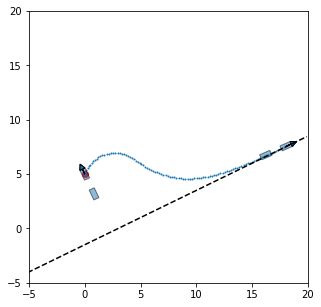

In [55]:
fig, ax = plt.subplots(figsize=[5,5])
bicycle.set_state(start,0)
bicycle.show()

final_state = sim.iloc[-1][['x','y','theta']].tolist()
bicycle.set_state(final_state,0)
bicycle.show()
plt.scatter(*start[:2], color='r')
draw_line(line)
plt.scatter(sim.loc[:,'x'], sim.loc[:,'y'], s=1);

### draw animation

In [61]:
from animake import AniMaker
anim = AniMaker()

In [62]:
fig, ax = plt.subplots(figsize=[5,5])
state = sim.loc[0,['x','y','theta']].tolist()
bicycle.set_state(state,0)
bicycle.show()
draw_line(line)

for i, row in sim.iterrows():
    state = row.loc[['x','y','theta']].to_numpy()
    gamma = row.loc['gamma']
    bicycle.set_state(state, gamma)
    bicycle.update();
    path = plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1, color='k')
    anim.set_snapshot()
    path.remove()
    
plt.close()

image added:  101


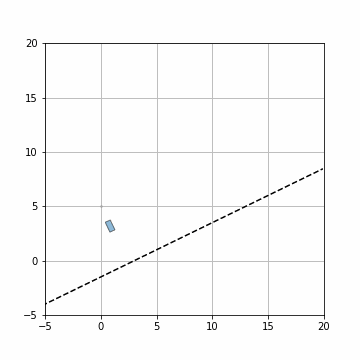

In [63]:
anim.make_gif('out_stanley.gif')
Image(filename="out_stanley.gif")